# rigidregistration: Detailed walk through
The code below provides a detailed walk-through demonstrating the use and features of the rigidregistration python package.  The package was designed for registering and averaging scanning transmission electron microscopy data, particulary in cases where low SNRs or periodicity-induced artifacts make registration difficult.  This notebook details features of the package designed to facilitate successful processing of these tricky cases.

If you find this code useful in your own research, please cite the associated publication:
"Image registration of low signal-to-noise cryo-STEM data", Ultramicroscopy (2018), DOI: 10.1016/j.ultramic.2018.04.008

### Getting started

These first few cells below are preparatory: importing the necessary python libraries and functions, loading and pre-inspecting the data, and instantiating (creating) the 'imstack' object, which contains most of the functions that will be used.

In this example, data which is formatted as .tif files are loaded using the tifffile package.  For other file formats common to electron microscopy data (e.g., .dm3, .ser...) we recommend the excellent hyperspy package for i/o handling.  See hyperspy.org.

In [2]:
# Import libraries and functions
import numpy as np
import matplotlib.pyplot as plt
from time import time
from tifffile import imread, imsave
import rigidregistration

%matplotlib

Using matplotlib backend: Qt5Agg


In [3]:
# Load data.  
# Final axis of stack variable should iterate over images.
# For best performance, data should be normalized between 0 and 1

f="sample_data/Nb3Cl8_cross_section.tif"           # Filepath to data
stack=np.rollaxis(imread(f),0,3)       # Rearrange axes so final axis iterates over images
stack=stack[:,:,:]/float(2**16)        # Normalize data between 0 and 1
print("Analyzing {}.".format(f))

Analyzing sample_data/Nb3Cl8_cross_section.tif.


In [4]:
# Inspect data in preparation for registration

for i in range(5,10):                      # Select which images from the stack to display
    fig,(ax1,ax2)=plt.subplots(1,2)
    ax1.matshow(stack[:,:,i],cmap='gray')
    ax2.matshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(stack[:,:,i])))),cmap='gray',vmin=np.average(np.log(np.abs(np.fft.fft2(stack[:,:,i]))))) 
    ax1.grid(False)
    ax2.grid(False)
    plt.show()

In [4]:
# Instantiate imstack object, and get all FFTs

s=rigidregistration.stackregistration.imstack(stack)    # Instantiage imstack object.
s.getFFTs()                                             # Calculate the FFTs of each image in the stack

### Fourier masking
Select a Fourier mask, defining which information will be weighted more or less to calculate the image shifts. 
There are two choices to be made: the cutoff frequency, and mask shape.  It is also possible to define a unique Fourier mask.

**1. The cutoff frequency**

In all cases, the parameter n controls the mask cutoff frequency; features smaller than ~n pixels will be ignored during image correlation.
For data with higher SNR, choosing a mask with n at the information limit is frequently sufficient.
For low-SNR data, choosing a mask with a cutoff frequency near the primary Bragg peaks is often preferable, as this heavily weights low frequency information to avoid unit-cell hops, but ideally contains just enough lattice information to 'lock-in' to the lattice.

**2. The mask shape**

Supported apodization functions for makeFourierMask() method are "bandpass", "lowpass", "hann", "hamming", "blackman", "gaussian", "none".
For lattices lacking high rotational symmetry, an anisotropic mask is generally preferable to avoid overweighting one lattice direction, discussed further below.
Details functional forms can be found in the source code.

**3. Defining a unique mask**

The imstack object contains several meshgrids which correspond to Fourier space coordinates, facilitating defining a unique Fourier mask.  See below.

In [5]:
# Explore mask shape options

# The displayed plots are:
# Left: The full FFT in black and white, with a colored, semitransparent overlay showing the mask
# Middle: The FFT multiplied by the weighting mask
# Right: The cross correlation of a selected pair of images, weighted by the chosen mask


masktypes=["bandpass","lowpass","hann","hamming","blackman","gaussian","none"]   # List of mask shapes
n=4                                                                              # Set cutoff frequency

i,j = 5,9                                    # Choose image pair to cross correlate
for masktype in masktypes:                   # Iterate over mask types
    s.makeFourierMask(mask=masktype,n=n)     # Set the selected Fourier mask
    s.show_Fourier_mask(i=i,j=j)             # Display results

In [6]:
# Vary n, the cutoff frequency

# In a typical workflow, this parameter is varied and the effect on the cross correlation is optimized

masktype="hann"

i,j = 5,9                                    # Choose image pair
for n in np.arange(2,12,2):                  # Select n values to test
    s.makeFourierMask(mask=masktype,n=n)     # Set the selected Fourier mask
    s.show_Fourier_mask(i=i,j=j)             # Display the results

In [8]:
# Elliptical Gaussian masks

# The makeFourierMask_eg() method creates an elliptical gaussian mask, with parameters n1, n2, and theta.
# n1, n2 define the cutoff frequencies along the two primary axes 
# theta defines the mask tilt, in degrees.

n1=4
n2=2
theta=20

s.makeFourierMask_eg(n1=n1,n2=n2,theta=np.radians(theta))   # Set the selected mask
s.show_Fourier_mask(i=i,j=j)                                # Display the results

In [6]:
# Vary elliptical Gaussian angle

# The three parameters (n1,n2,theta) can be varied and optimized.

n1=4
n2=2
thetas=[90,75,60,45,30,15,0]

i,j = 5,9
for theta in thetas:
    s.makeFourierMask_eg(n1=n1,n2=n2,theta=np.radians(theta))
    s.show_Fourier_mask(i=i,j=j)

In [38]:
# Define a unique mask

# There are three attributes of the imstack object which define Fourier space coordinates, and can be used to define 
# a Fourier mask.  kx and ky define rectangular Fourier coordinates, and kr defines polar Fourier coordinates.
# See the examples below.

circular_mask = np.abs(s.kr)<50                      # Make a circular mask
s.makeUserDefinedFourierMask(circular_mask)          # Set mask
s.show_Fourier_mask()

square_mask = (np.abs(s.kx)<50)*(np.abs(s.ky)<50)    # Make a square mask
s.makeUserDefinedFourierMask(square_mask)            # Set mask
s.show_Fourier_mask(i=i,j=j)

kmax=s.nx/4                                          # Set cutoff frequency
barlett_mask = (s.kr<kmax)*(1 - s.kr/kmax)           # Make bartlett mask
s.makeUserDefinedFourierMask(barlett_mask)           # Set mask
s.show_Fourier_mask(i=i,j=j)

### Calculate image shifts
Calculate the relative shifts between all pairs of images from their cross correlations.

Analytically, for two functions which are identical except for some shift, the shift is given by the maximum value of their cross correlation.
After calculating the cross correlation, here it's maximum may be found in one of two ways: finding the brightest pixel, or fitting gaussian functions.  Which method is used is controlled by the findMaxima parameter.

** 1. Brightest pixel **

The shift is given directly by the position of the brightest pixel in the cross correlation.  This is the fastest approach, and is selected by setting findMaxima="pixel".  In this approach, the relative shifts are determined with resolution of 1 pixel; however, the final shifts which are applied to the images before averaging will be determined using all of the relative image shifts between all pairs of images, thus the final shifts may still be determined with subpixel resolution, with an accuracy that generally improves with the number of images in the stack.

** 2. Gaussian fitting **

Fitting a continuous function to the maximum of the cross correlation is a simple way to find the shift between an image pair with subpixel resolution.  For images of atomic lattices, a Gaussian is a natural choice for a fitting function.

For images of crystal lattices, 'unit cell hop' errors can occur, wherein the calculated shift between a pair of images is incorrect by a multiple of the primitive lattice vectors.  Unit cell hops become increasingly common due to sampling error when the real space sampling of the image is low enough that each atomic column is only a handful of pixels across.  Fitting a continuous function can correct for this sampling error, by performing Gaussian fits to several regions near the brighest several pixels, and then finding the cross correlation maximum using these continuous fits.

This method is selected by setting findMaxima="gf".  Before running the Gaussian fitting method, three additional parameters for the fitting should be set by calling s.setGaussianFitParams().  These are:

  * sigma_guess: sets the initial guess for the standard deviation of the guassian fits, in pixels.  This may be estimated simply and quickly by observing the peak widths in the cross correlations or the width of atomic columns in the raw data.

  * window_radius: sets the size of the region about the brightest pixel which is used to fit a gaussian.  Should be set such that neighboring cross correlation peaks are excluded; the window used is a square region of size length 2xwindow_radius+1.

  * num_peaks: sets how many of the brightest pixels to fit gaussians to. Typically 3-5 are sufficient to handle sampling problems.  

In [6]:
# Make elliptical Gaussian mask.
# The type and parameters of the Fourier mask are determined by varying parameters in the previous section.

n1=12
n2=9.106
theta=1.42

s.makeFourierMask_eg(n1=n1,n2=n2,theta=theta)
s.show_Fourier_mask(i=i,j=j)

/Users/Ben/Work/Projects/Active/rigidRegistration/code/rigidRegistration/rigidregistration/display.py:152: RuntimeWarning: divide by zero encountered in log
  ax2.matshow(np.log(np.abs(np.fft.fftshift(imstack.fftstack[:,:,i]*np.where(imstack.mask_fourierspace,imstack.mask_fourierspace,0.0001)))), cmap='gray',


In [7]:
# Calculate image shifts using brightest cross correlation pixel

findMaxima = 'pixel'

t0=time()                                                  # Start time 
s.findImageShifts(findMaxima=findMaxima,verbose=False)     # Find shifts.  Set verbose=True to print the correlation status to screen
t=time()-t0                                                # End time
print("Performed {} correlations in {} minutes {} seconds".format(int(s.nz*(s.nz-1)/2),int(t/60),t%60))

Performed 351 correlations in 0 minutes 2.3710169792175293 seconds


In [8]:
# Calculate image shifts using gaussian fitting

findMaxima = 'gf'
s.setGaussianFitParams(num_peaks=3,sigma_guess=3,window_radius=4)

t0=time()                                                  # Start time 
s.findImageShifts(findMaxima=findMaxima,verbose=False)     # Find shifts.  Set verbose=True to print the correlation status to screen
t=time()-t0                                                # End time
print("Performed {} correlations in {} minutes {} seconds".format(int(s.nz*(s.nz-1)/2),int(t/60),t%60))

Performed 351 correlations in 0 minutes 10.754011869430542 seconds


### Find and correct outliers in shift matrix
The previous step determines the relative shifts between all pairs of images.  Here, any incorrectly calculated shifts -- which may result from noisy, low SNR data -- are identified and corrected.  First, the shift matrix is displayed and inspected.  Next, outliers are identified.  Outliers are then corrected.

** 1. Display the shift matrix **

For a stack of $N$ images, there are $N-1$ relative shifts for each image.  The complete set of relative shifts is stored in an $NxN$ matrix.  Element $i,j$ of the shift matrix gives the relative shift of image $i$ with respect to image $j$.<sup>1</sup>  To be physically consistent, the relative image shifts must add vectorially, i.e. $\mathbf{r}_{ij} + \mathbf{r}_{jk} = \mathbf{r}_{ik}$.  In this step, we enforce physical consistency in the shift matrix.  Visually, a correct shift matrix should appear "smooth" (though not necessarily varying monotonically).

** 2. Identify outliers **

Several approaches are possible to identify outliers in the shift matrix.  

The recommended method is by enforcing transitivity, using s.get_outliers().  There is one required parameter and one optional parameter.  The required parameter is a threshhold value - higher threshhold values permit greater deviations from perfect transitivity.  The optional parameter is the number of transitivity relationships used to evaluate a given relative image shift - for example, $\mathbf{r}_{12} + \mathbf{r}_{24} = \mathbf{r}_{14}$ and $\mathbf{r}_{13} + \mathbf{r}_{34} = \mathbf{r}_{14}$ are two distinct transitivity relationships that can be used to evaluate the self consistency of the relative image shift from image 1 to image 4.

A simpler method to detect outliers is to require that each matrix element does not differ but too great an amount from its nearest neighbor elements, which roughly corresponds to enforcing the the shift matrix is "smooth".  The single required paramater is a threshhold value.

Finally, if necessary, outliers can be directly identified manually.

** 3. Correct outliers **

Outliers are corrected by extrapolating the correct values of any identified outliers using the transistivity relations.


<sup>1</sup>  But who needs ImageJ, amirite?

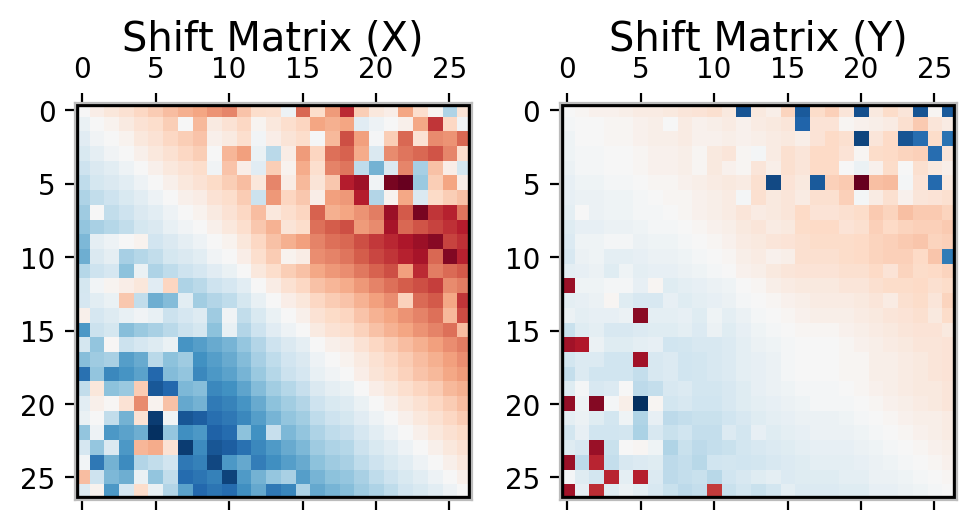

In [8]:
# Show Xij and Yij matrices
s.show_Rij()

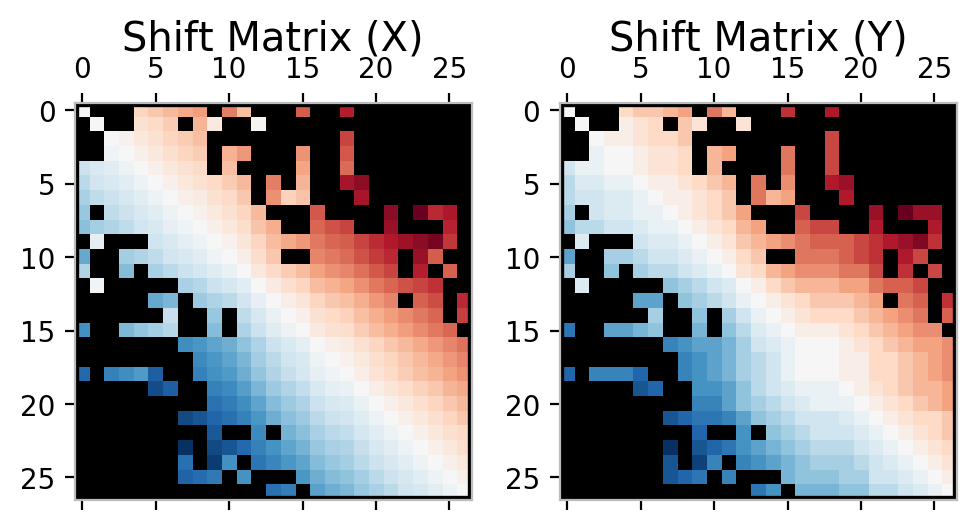

In [10]:
# Identify outliers by enforcing transitivity

s.get_outliers(threshold=10)              # Set outlier threshhold
s.show_Rij()

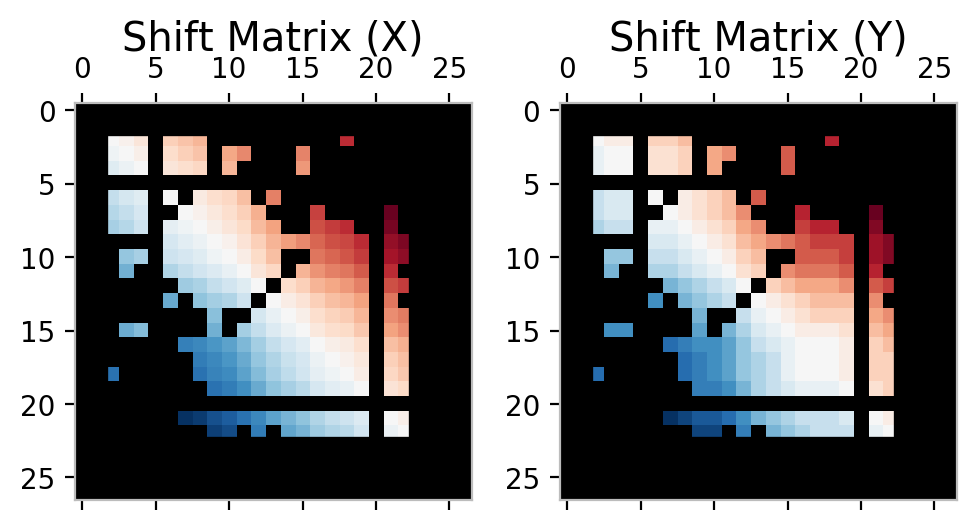

In [18]:
# Identify outliers by enforcing transitivity, using additional optional featurs

s.set_nz(2,23)                                 # Select a subset of the images to use by setting min/maz useable image indices
s.get_outliers(threshold=10,maxpaths=10)       # Set outlier threshhold and maxpaths
s.set_bad_images([5,20])                       # Flag entire images (rows/columns of shift matrix) as unuseable

s.show_Rij(mask=True)

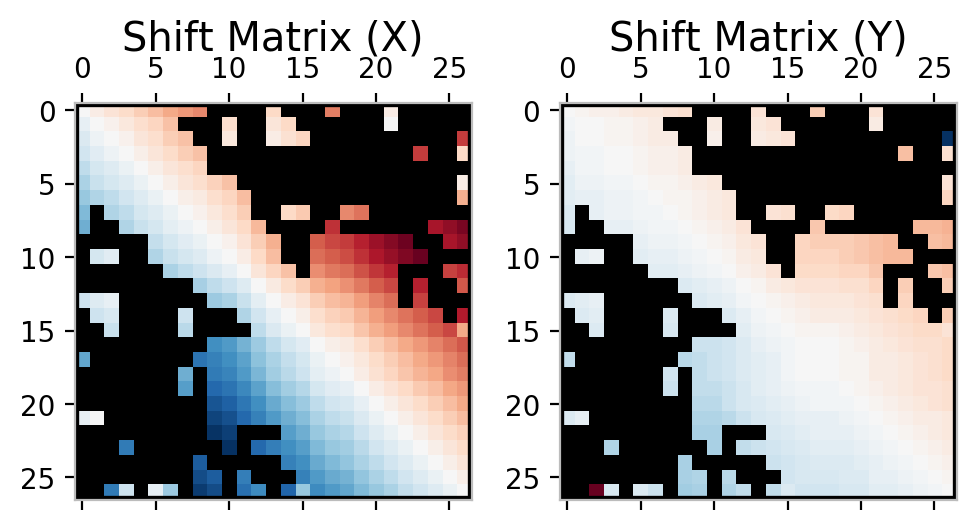

In [24]:
# Identify outliers using nearest neighbors to enforce "smoothness"

s.set_nz(0,s.nz)                                 # Select a subset of the images to use by setting min/maz useable image indices
s.get_outliers_NN(max_shift=8)       # Set outlier threshhold and maxpaths
s.set_bad_images([])                           # Flag entire images (rows/columns of shift matrix) as unuseable

s.show_Rij(mask=True)

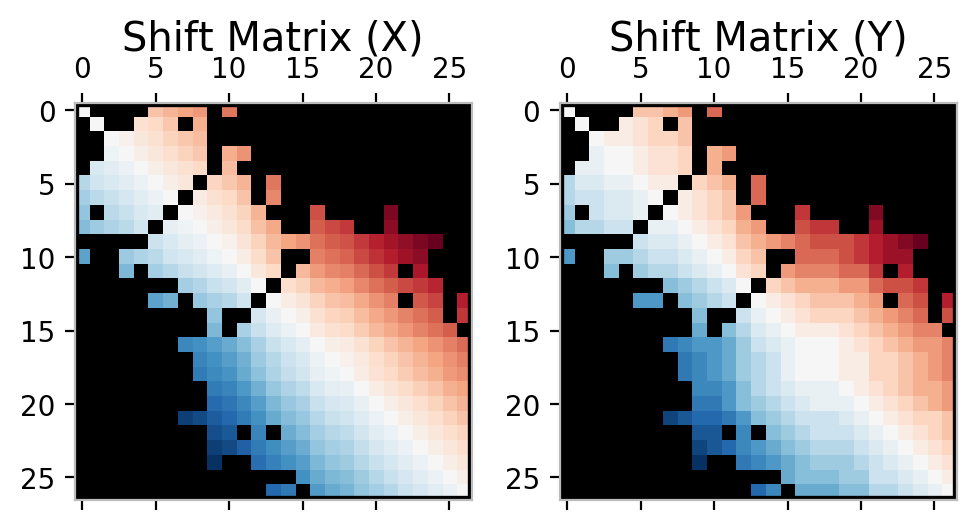

In [9]:
# Manually add or remove matrix elements that were not correctly identified
# This is done by directly altering s.Rij_mask, an NxN matrix which identifies elements of the shift matrix as correct or incorrect

s.get_outliers(10,10)

# Re-assign individual shift matrix elements
correct_elements=[[11,12],[11,13]]
incorrect_elements=[[1,9]]
for element in correct_elements:
    i,j=element[0],element[1]
    s.Rij_mask[i,j]=1
    s.Rij_mask[j,i]=1
for element in incorrect_elements:
    i,j=element[0],element[1]
    s.Rij_mask[i,j]=0
    s.Rij_mask[j,i]=0

# Re-assign blocks of the shift matrix
s.Rij_mask[:5,15]=0
s.Rij_mask[:3,18]=0
s.Rij_mask[:8,24:26]=0
s.Rij_mask[15,:5]=0
s.Rij_mask[18,:3]=0
s.Rij_mask[24:26,:8]=0

s.show_Rij()

In [10]:
# Correct outliers

# This step is optional, as it is performed automatically when get_average_image() is run if not called manually.
# However, manually calling make_corrected_Rij() is recommended so that the final shift matrices can be visually 
# inspected to ensure physical consistency.

s.make_corrected_Rij()    # Correct outliers using the transitivity relations
s.show_Rij_c()            # Display the corrected shift matrix

### Calculate average image

To obtain the average image, each image in the stack is shifted by an amount which is calculated from the shift matrix.  The entire, shifted image stack is then averaged.  Several functions are available for displaying and saving the resulting average image, and for summarizing the processing that's been applied to the data for quick review.

** 1. Shifting and averaging **

The final shifts which are applied to each image in the stack are determined by averaging each row of the shift matrix, i.e. the shift applied to the $i$'th image is 

$\mathbf{r}_i = \frac{1}{N}\sum_{j}\mathbf{R}_{ij}$

Shifts are applied in Fourier space using the shift theorem.  Running s.get_average_image() calculates the shifts, shifts the images, and calculates the average image.  The final shifts which have been applied to the data are stored in s.shifts_x and s.shifts_y, and the shifted image stack is stored in s.stack_registered.

** 2. Displaying and saving reports and averaged images **

The averaged image can be displayed and saved by running s.show() and s.save(), respectively.
A summary of all the processing that's been performed on the data can be displayed and saved by running s.show_report() and s.save_report(), respectively.  Saving a report is highly recommended, as it allows quick assessment of the fidelity of the final images.

The s.save() method saves a .tif file of the average image.  Metadata with the processing parameters used to create the average image are stored in the description string of the .tif file.

Note that because images have been shifted, a region about the edges of the final image will no longer be meaningful and should be discarded.  The s.save() method automatically discards unmeaningful edge data.  To keep the full field of view in the final output, pass the key:value pair crop=False to s.save().  In this case, be sure to exclude the edge region from any final analysis.  The min/max values delineating meaningful data are stored as s.xmin, s.xmax, s.ymin, and s.ymax.

In [11]:
# Create registered image stack and average

s.get_averaged_image()   # To skip calculation of image shifts, or correcting the shift matrix, pass the function
                         # get_shifts=False, or correct_Rij=False

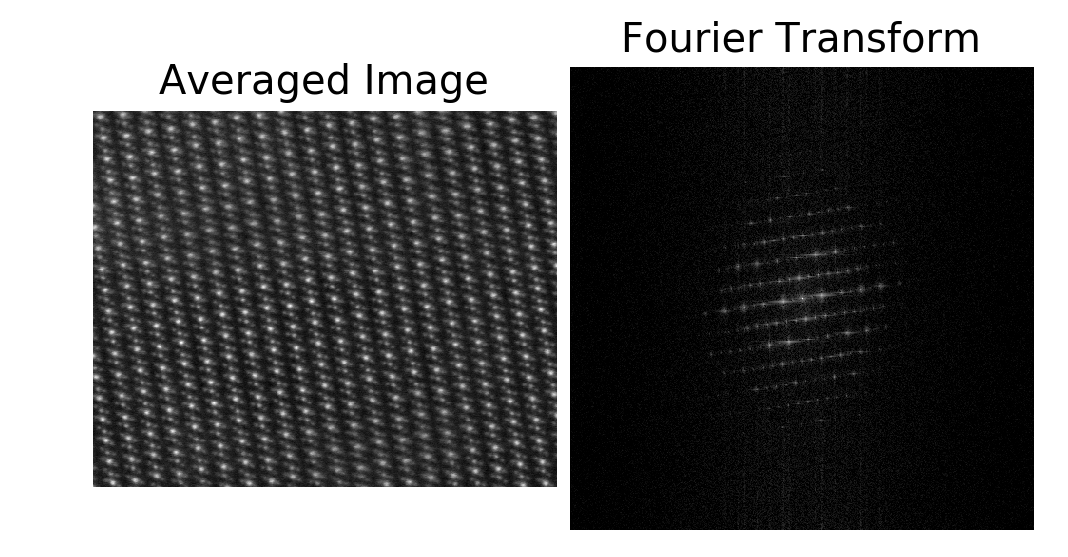

In [12]:
# Display final image

s.show()                 # To display the full field of view, including edge regions, use crop=False

In [12]:
# Display report of registration procedure

s.show_report()

In [13]:
# Save report of registration procedure

s.save_report("/Users/Ben/Desktop/test_report.pdf")

In [14]:
# Save the average image

s.save("/Users/Ben/Desktop/test_image.tif")     # To keep the image uncropped, use crop=False.  The appropriate 
                                                # cropping boundaries are stored as metadata in the description string
                                                # of the output .tif file.